In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from glob import glob
import os

data_dir = "../../archive/chest_xray"

train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

len(glob(f"{train_dir}/*/*.jpeg")), len(glob(f"{test_dir}/*/*.jpeg"))

(5216, 640)

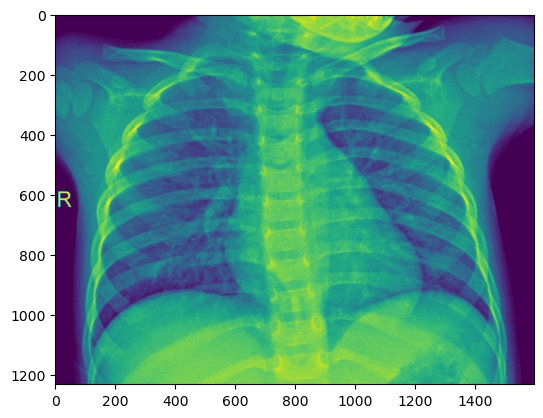

In [2]:
import matplotlib.pyplot as plt

plt.imshow(plt.imread(glob(f"{train_dir}/*/*")[0]))

In [3]:
import cv2

train_image = []
train_label = []
test_image = []
test_label = []

for i in range(len(glob(f"{train_dir}/*/*"))):
    temp_image = cv2.imread(glob(f"{train_dir}/*/*")[i])
    train_image.append(temp_image)
    
    temp_label = glob(f"{train_dir}/*/*")[i].split('/')[-2]
    if temp_label == 'PNEUMONIA':
        train_label.append(1)
    else:
        train_label.append(0)
        
for i in range(len(glob(f"{test_dir}/*/*"))):
    temp_image = cv2.imread(glob(f"{test_dir}/*/*")[i])
    test_image.append(temp_image)
    
    temp_label = glob(f"{test_dir}/*/*")[i].split('/')[-2]
    if temp_label == 'PNEUMONIA':
        test_label.append(1)
    else:
        test_label.append(0)

ModuleNotFoundError: No module named 'cv2'

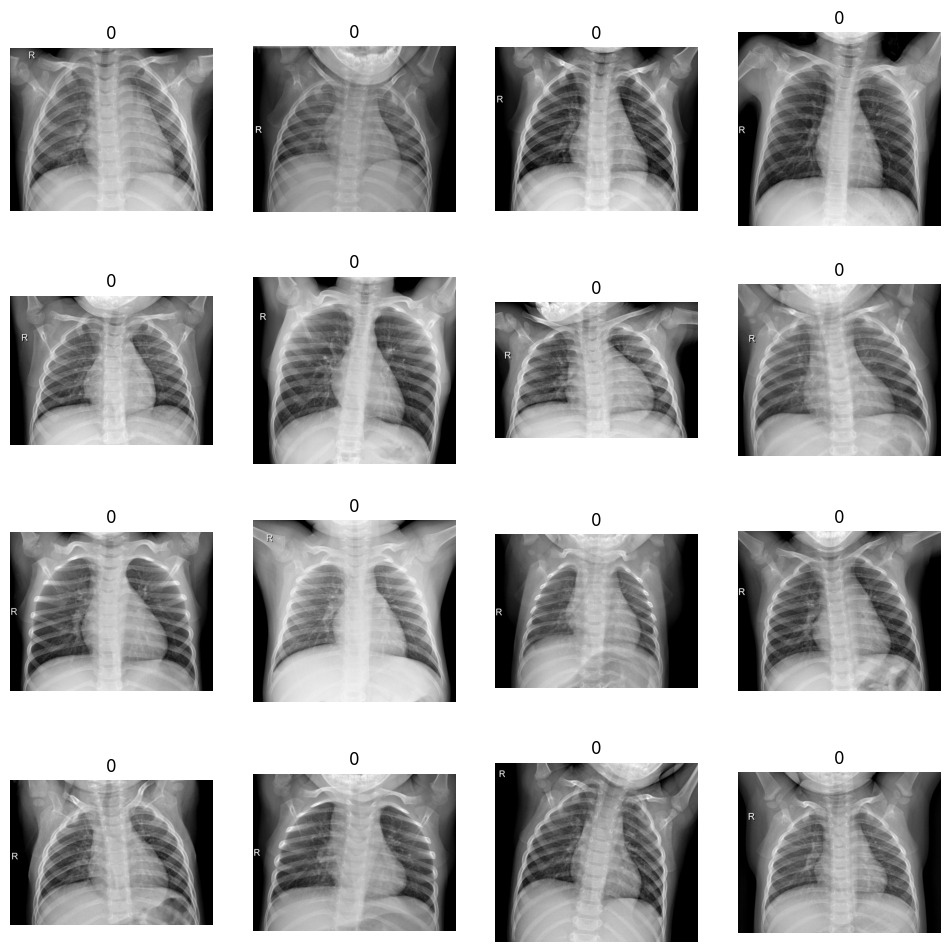

In [7]:
plt.figure(figsize=(12, 12))
for i in range(16):
    img = train_image[i+4000]
    plt.subplot(4, 4, i + 1)
    plt.title(train_label[i+4000])
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()

In [29]:
from sklearn.model_selection import train_test_split

train_image, val_image, train_label, val_label = train_test_split(train_image, train_label, test_size=0.15, stratify=train_label)

In [30]:
print(len(train_image), len(val_image), len(test_image))

4433 783 640


In [166]:
from torchvision import transforms
# 쿠다 때문에 사이즈가 (64, 64) 밖에 안되는데 이게 맞나?
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [167]:
from PIL import Image
import torch

class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform):
        self.transform = transform
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        x = Image.fromarray(self.x[index])
        x = self.transform(x)
        y = self.y[index]
        
        return x, y

In [168]:
train_ds = custom_dataset(train_image, train_label, train_transform)
val_ds = custom_dataset(val_image, val_label, val_transform)
test_ds = custom_dataset(test_image, test_label, test_transform)

In [169]:
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=32)

In [170]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([32, 3, 64, 64]) torch.Size([32])


In [178]:
import torch.nn as nn

class Find_PNEUMONIA(nn.Module):
    def __init__(self):
        super(Find_PNEUMONIA, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear = nn.Linear(16 * 16 * 128, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 16 * 16 * 128)
        x = self.linear(x)
        x = self.sigmoid(x)
        
        return x

In [179]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [180]:
model = Find_PNEUMONIA().to(device)
print(model)

Find_PNEUMONIA(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=32768, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [181]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [185]:
from sklearn.metrics import accuracy_score
import tqdm

def train_validate(model, train_dataloader, val_dataloader, optimizer, criterion, epochs):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(epochs):
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        model.train()
        
        for data, target in tqdm.tqdm(train_dataloader):
            
            data = data.to(device)
            target = target.to(device)
            
            y_pred = model(data)
            print(y_pred)
            loss = criterion(y_pred, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            epoch_train_acc += acc
            
        avg_train_loss = epoch_train_loss / len(train_data_loader)
        avg_train_acc = epoch_train_acc / len(train_dataloader)
        
        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        
        print(f'Epoch: {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train ACC: {avg_train_acc:.4f}')
        
    return train_losses, train_accs

In [183]:
epochs=10

In [186]:
train_losses, train_accs = train_validate(model, train_dataloader, val_dataloader, optimizer, criterion, epochs)

  0%|          | 0/139 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 30.12 MiB is free. Process 2572 has 14.71 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 35.34 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)